Here is one of the most common misconceptions that I see people have when thinking about probability, in particular repeated coin tosses: 

"Tossing a fair coin n times will give you roughly the same number of heads and tails."

To formalize, let's say you have iid $X_1, \dots, X_n$, where $X_i \sim Bi(p)$, that is, $X_i = \begin{cases} 1, & p \\ -1, & 1-p \end{cases}$.

Lets define the walk $S_t=\sum_{i}^t X_i$.

then, the assertion is $P(S_n = 0) \text{ is high}$  

In fact, the opposite is true:

$P(S_n=0) = \frac{\binom{n}{n/2}}{2^n} \sim \sqrt{\frac{2}{\pi n}} \to 0$ as $n \to \infty$

For example, $n=10: 0.246, n=100: \sim 0.08, n=1000: \sim 0.025$


We test our intuition today with a little experiment.

We are going to be looking at trajectories, where each point is $(t, S_t)$.

If $S_t$ is zero, then we have the same number of tails and heads at time $t$.

Our intuition tells us:

- The most probable trajectory for a series of coin tosses is when we have some fluctuations at the start (say, first 30 or 100 steps), but then it oscilates around 0.

- The last tie in a series of coin tosses is very close to $n$ (near the end).

- Around half of the time the trajectory will spend on "the positive" side (that is, $S_t > 0$ for half the $t$'s)

- The lead changes frequently

- Streaks are unlikely: we not spend much time on either side.

- Gambler's fallacy: being far from 0 makes a quick return to 0 more likely.

- The maximum displacement, $max_t|S_t|$ is small.


Here is somewhat our expectations summarized:

Text(0, 0.5, 'S_t')

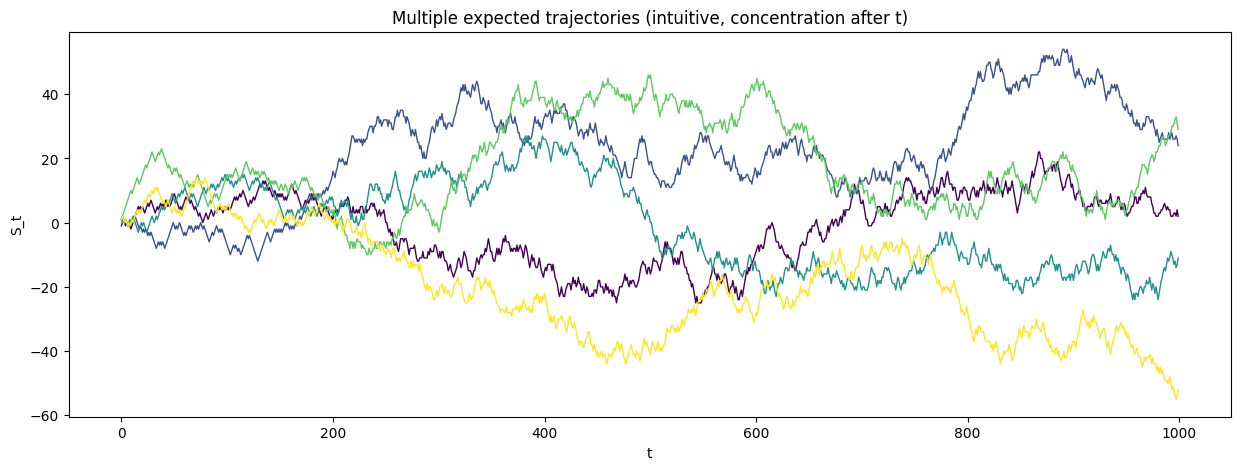

In [60]:
#| echo: false
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
n = 1000

def expected_trajectory(n, rng, t_conc=200, fluct=2):
    s = np.empty(n, dtype=int)
    s[:t_conc] = rng.choice([-1, 1], size=t_conc)
    s[t_conc:n] = rng.integers(-fluct, fluct + 1, size=n - t_conc)
    Snm1 = s[:n-1].cumsum()[-1]
    s[-1] = -Snm1 if abs(Snm1) <= fluct else -np.sign(Snm1) * fluct
    return s.cumsum()

num_traj = 5
S_exps = [expected_trajectory(n, np.random.default_rng(seed)) for seed in range(42, 42 + num_traj)]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

colors = plt.cm.viridis(np.linspace(0, 1, num_traj))
for S_exp, c in zip(S_exps, colors):
    ax.plot(S_exp, color=c, lw=1)
ax.set_title("Multiple expected trajectories (intuitive, concentration after t)")
ax.set_xlabel("t")
ax.set_ylabel("S_t")

And here are the actual trajectories:

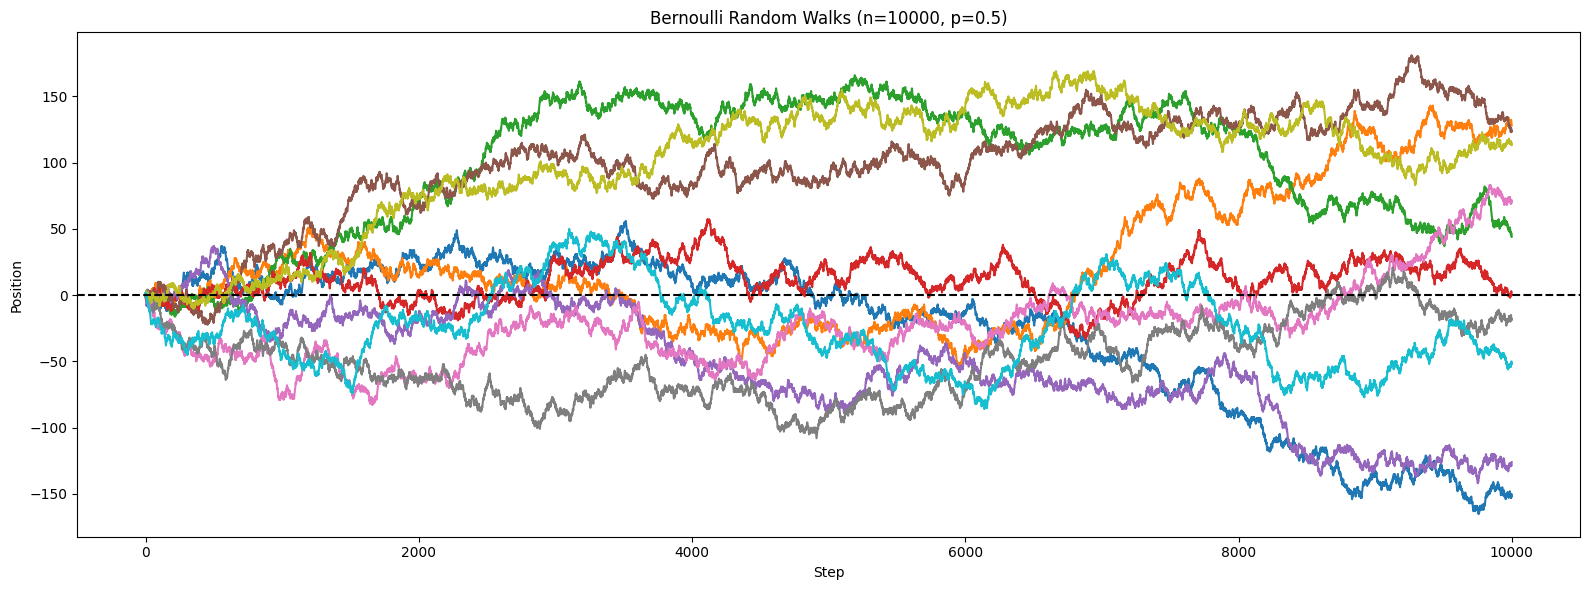

In [49]:
#| echo: false
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)

n = 10_000
num_samples = 10
p = 0.5

fig, ax = plt.subplots(1, 1, figsize=(16, 6))

for i in range(num_samples):
    steps = np.random.choice([-1, 1], size=n, p=[1-p, p])
    walk = np.cumsum(steps)
    ax.plot(walk, label=f'Sample {i+1}')
ax.axhline(0, color='black', linestyle='--')
ax.set_title(f"Bernoulli Random Walks (n={n}, p=0.5)")
ax.set_xlabel("Step")
ax.set_ylabel("Position")

plt.tight_layout()
plt.show()


And here are the distributions of some core statistics:

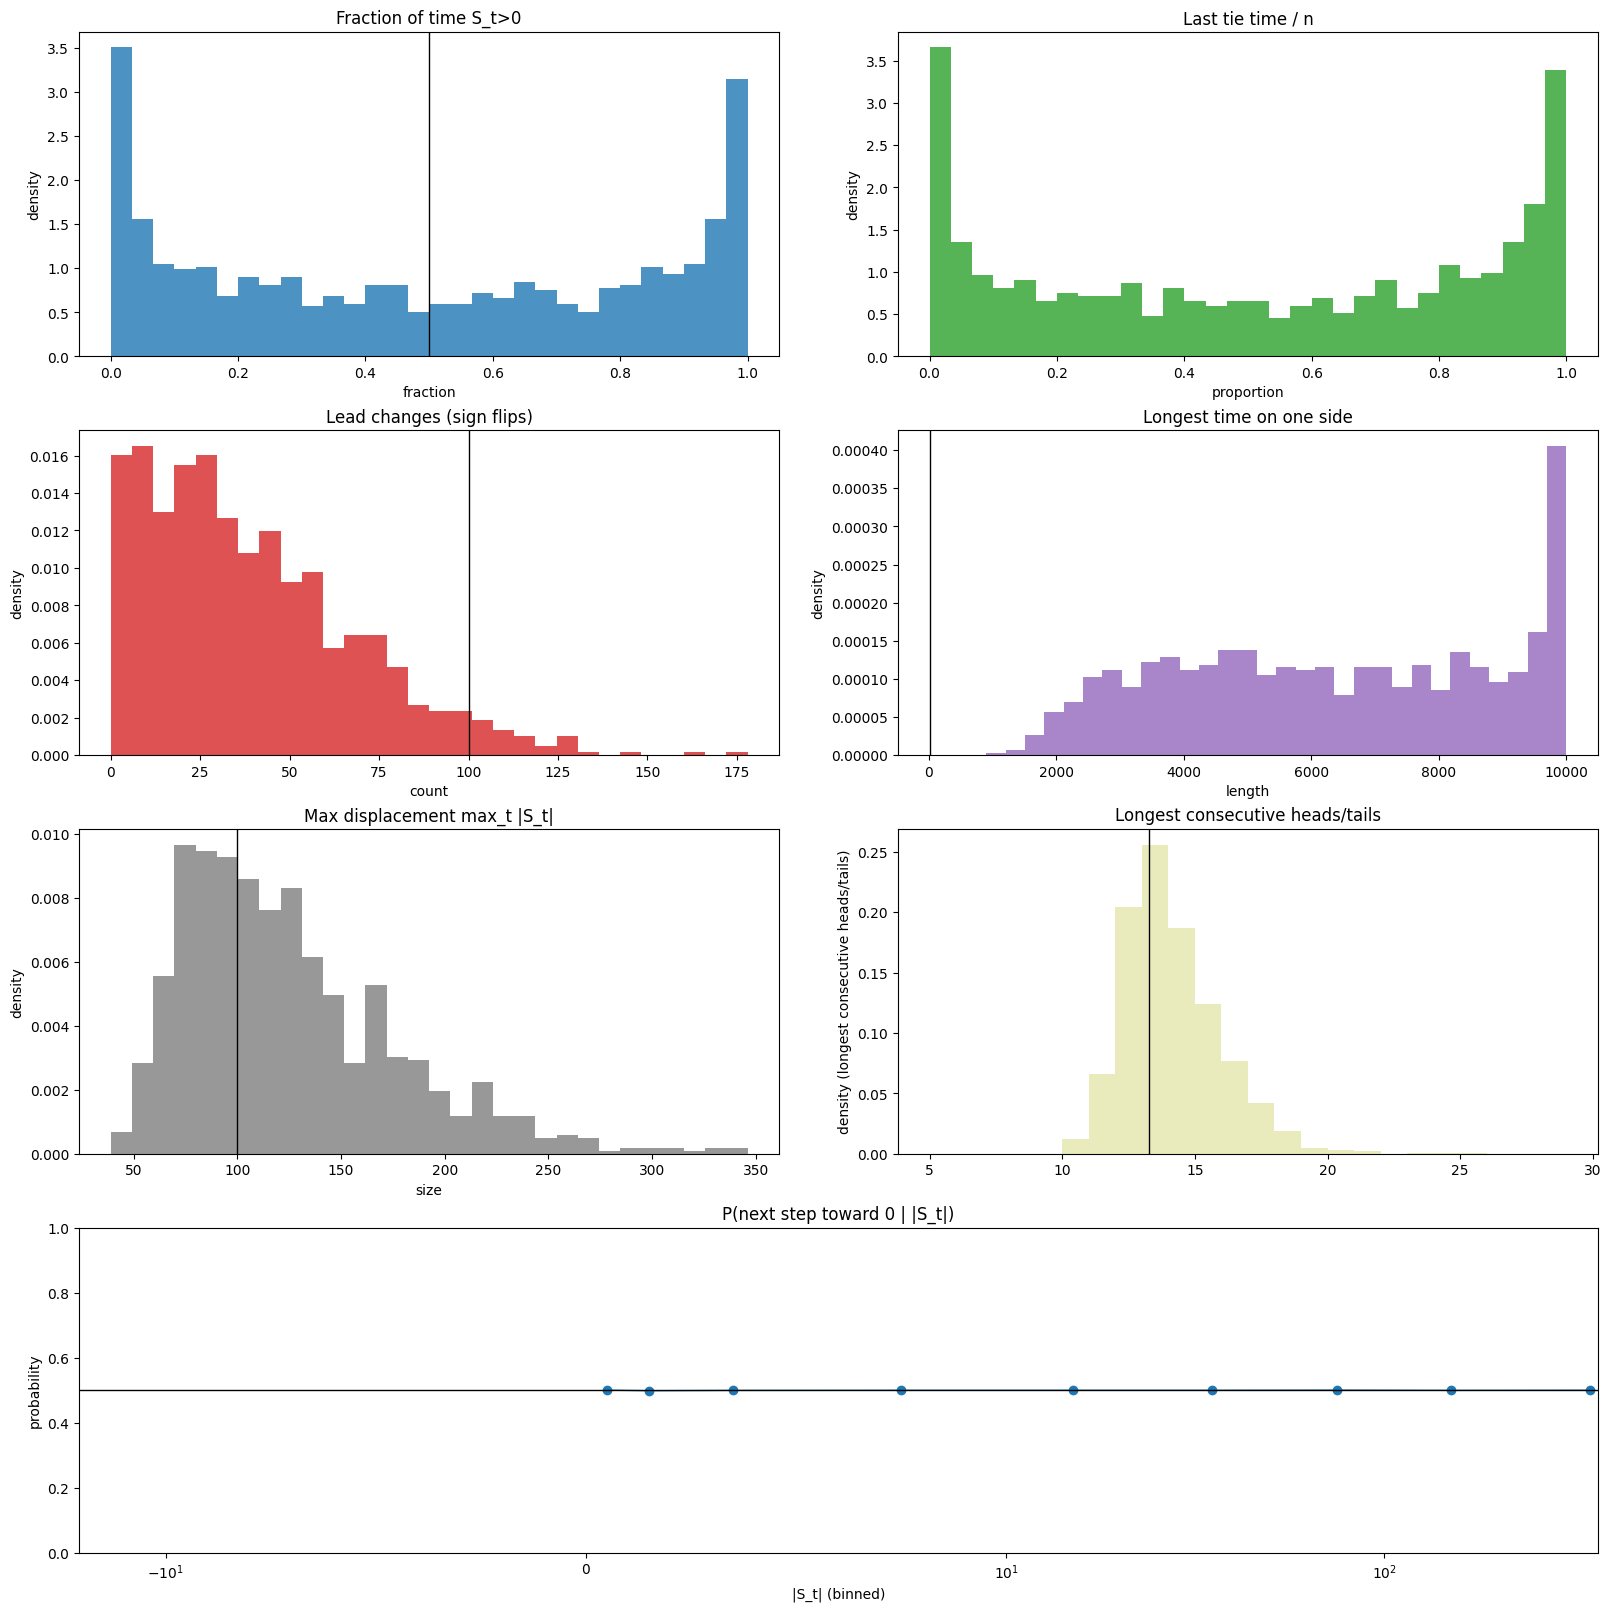

In [57]:
#| echo: false
n = 10_000
M = 1_000

steps = rng.choice([-1, 1], size=(M, n))
S = steps.cumsum(axis=1)

frac_pos = (S > 0).mean(axis=1)

mask_zero = (S == 0)
has_zero = mask_zero.any(axis=1)
last_zero = np.full(M, -1, dtype=int)
rz = mask_zero[:, ::-1]
idx_rev = np.argmax(rz, axis=1)
lz = n - 1 - idx_rev
last_zero[has_zero] = lz[has_zero]
last_zero_prop = np.where(last_zero >= 0, last_zero / n, 0.0)

sgn = np.sign(S)
idx = np.where(sgn != 0, np.arange(n), 0)
idx_prev = np.maximum.accumulate(idx, axis=1)
sgn_ff = sgn[np.arange(M)[:, None], idx_prev]
sgn_ff[:, 0] = np.where(sgn_ff[:, 0] == 0, 1, sgn_ff[:, 0])
chg = np.empty_like(sgn_ff, dtype=bool)
chg[:, 0] = True
chg[:, 1:] = sgn_ff[:, 1:] != sgn_ff[:, :-1]
sign_changes = chg[:, 1:].sum(axis=1)

longest_run = np.empty(M, dtype=int)
for i in range(M):
    idx_i = np.flatnonzero(chg[i])
    lengths = np.diff(np.append(idx_i, n))
    longest_run[i] = lengths.max()

max_abs = np.max(np.abs(S), axis=1)

S_mid = S[:, :-1]
step_next = steps[:, 1:]
mk = S_mid != 0
toward_zero = (np.sign(S_mid[mk]) * step_next[mk]) == -1
absS = np.abs(S_mid[mk])
bins = np.array([1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000])
bix = np.digitize(absS, bins, right=True)
cnt = np.bincount(bix, minlength=bins.size + 1)
sum_tow = np.bincount(bix, weights=toward_zero.astype(float), minlength=bins.size + 1)
with np.errstate(invalid='ignore'):
    p_tow = np.where(cnt > 0, sum_tow / cnt, np.nan)
bin_left = np.r_[0, bins[:-1]]
bin_right = bins
bin_centers = 0.5 * (bin_left + bin_right)

fig = plt.figure(figsize=(16, 16), constrained_layout=True)
gs = fig.add_gridspec(4, 2)
ax00 = fig.add_subplot(gs[0, 0])
ax01 = fig.add_subplot(gs[0, 1])
ax10 = fig.add_subplot(gs[1, 0])
ax11 = fig.add_subplot(gs[1, 1])
ax20 = fig.add_subplot(gs[2, 0])
ax21 = fig.add_subplot(gs[2, 1])
ax30 = fig.add_subplot(gs[3, :])

ax00.hist(frac_pos, bins=30, density=True, color='tab:blue', alpha=0.8)
ax00.axvline(0.5, color='black', lw=1)
ax00.set_title("Fraction of time S_t>0")
ax00.set_xlabel("fraction")
ax00.set_ylabel("density")

ax01.hist(last_zero_prop, bins=30, density=True, color='tab:green', alpha=0.8)
ax01.set_title("Last tie time / n")
ax01.set_xlabel("proportion")
ax01.set_ylabel("density")

ax10.hist(sign_changes, bins=30, density=True, color='tab:red', alpha=0.8)
ax10.axvline(np.sqrt(n), color='black', lw=1)
ax10.set_title("Lead changes (sign flips)")
ax10.set_xlabel("count")
ax10.set_ylabel("density")

ax11.hist(longest_run, bins=30, density=True, color='tab:purple', alpha=0.8)
ax11.axvline(np.log2(n), color='black', lw=1)
ax11.set_title("Longest time on one side")
ax11.set_xlabel("length")
ax11.set_ylabel("density")

ax20.hist(max_abs, bins=30, density=True, color='tab:gray', alpha=0.8)
ax20.axvline(np.sqrt(n), color='black', lw=1)
ax20.set_title("Max displacement max_t |S_t|")
ax20.set_xlabel("size")
ax20.set_ylabel("density")

def longest_consecutive_run(a):
    idx = np.flatnonzero(np.r_[True, a[1:] != a[:-1], True])
    return np.diff(idx).max()

longest_flip_run = np.array([longest_consecutive_run(steps[i]) for i in range(M)])


ax21.hist(longest_flip_run, bins=np.arange(5, 30), density=True, color='tab:olive', alpha=0.3)
ax21.axvline(np.log2(n), color='black', lw=1)
ax21.set_ylabel("density (longest consecutive heads/tails)")
ax21.set_ylim(0, ax21.get_ylim()[1])
ax21.set_title("Longest consecutive heads/tails")

ax30.plot(bin_centers, p_tow[:bin_centers.size], marker='o', lw=1)
ax30.axhline(0.5, color='black', lw=1)
ax30.set_xscale('symlog', linthresh=10)
ax30.set_ylim(0, 1)
ax30.set_title("P(next step toward 0 | |S_t|)")
ax30.set_xlabel("|S_t| (binned)")
ax30.set_ylabel("probability")


plt.show()

What this shows:

- **Last tie is not near the end**: actually, it follows the **arcsine law**, the distribution is symmetric, with high probabilities of both start and end.

- **It is very unlikely to spend half of the time on either side**: it follows the same arcsine law: all positive and all negative are the most likely values.

- **Lead changes are not “frequent” in a linear sense**: the number of sign flips is on the order of $\sqrt{n}$

- **Long streaks are expected**: the longest run grows like $\log_2 n$.

- **No mean-reversion force**: the last axis show that regardless of the displacement, the probability of taking a step towards zero is $0.5$. This is trivial, of course, since the steps we take are independent.


## So why did our intuition fail us?

The random walk is fair in the sense that $E[S_n]=0$ and the ditribution of $S_n$ is symmetric. Some might find it tempting to assume that it implies "it should stay near 0".

Some people might misinterpret the law of large number and think that $S_n \rightarrow 0 $ as $n \rightarrow \inf$, while what it actually gives us is $S_n/n \rightarrow 0$, which basically says that the average step tends to zero.

$0$ is indeed the most like value that $S_n$ takes (the mode), but the problem is the distribution of $S_n$ "spread out" as $n$ grows:

$$Var(S_n) = n$$

So the trajectories will lie in a $\pm\sqrt{t}$ band.

From CLT, $\frac{S_t}{\sqrt{t}} \rightarrow \mathcal{N}(0, 1)$, so $P(|S_t|\le 2 \sqrt{t}) \sim 95\%$

Text(0, 0.5, 'S_t')

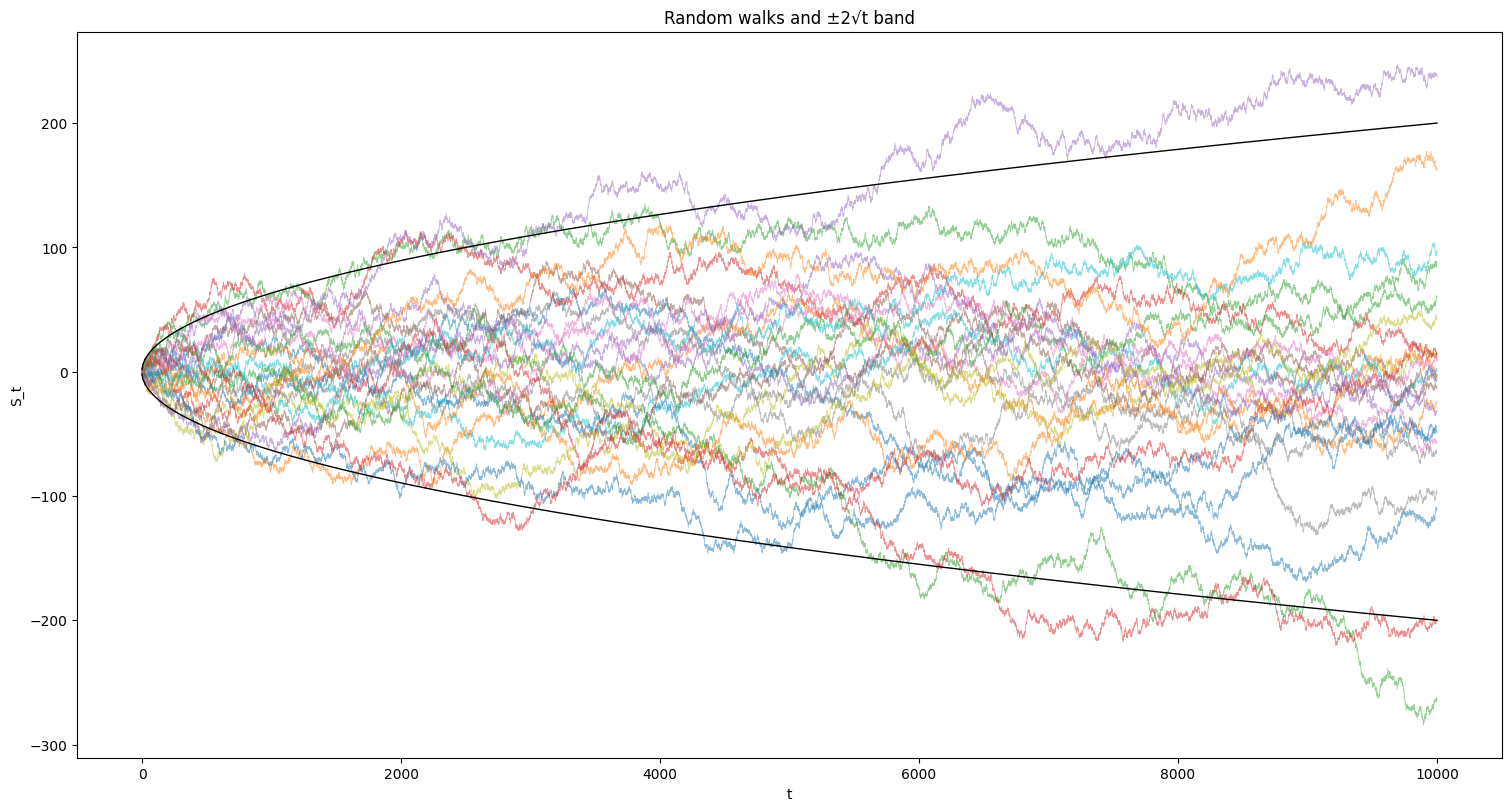

In [69]:
#| echo: false
n = 10_000
M = 1_000

t = np.arange(1, n + 1)
sqrt_t = np.sqrt(t)


steps = rng.choice([-1, 1], size=(M, n))
S = steps.cumsum(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout=True)


for i in range(25):
    ax.plot(S[i], alpha=0.5, lw=0.6)
ax.plot(2 * sqrt_t, color='black', lw=1)
ax.plot(-2 * sqrt_t, color='black', lw=1)
ax.set_title("Random walks and ±2√t band")
ax.set_xlabel("t")
ax.set_ylabel("S_t")